
In this Python notebook, we applied transfer learning techniques using LoRA and DoRA. Each model underwent training and evaluation at every epoch using the validation set. Finally, we conducted a final assessment on the test set for each technique. You can find the accuracy and loss results of VGG16, AlexNet, ResNet, and DenseNet in this notebook.

### <img src="icons/resized/library.png" style="height:50px;display:inline"> Libs
Import libraries for the project:


In [2]:
# Standard library imports
import os
import copy
import time
import csv
# Data handling and visualization
import numpy as np
import pandas as pd
# PyTorch imports for neural network architecture and data handling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# torchvision for pre-trained models, datasets and image transformations
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image

### <img src="icons/resized/dataset.png" style="height:50px;display:inline"> Dataset
Load the training and validation datasets and convert them into data loaders. Apply transformations to resize the images to 224x224 and normalize them.

In [ ]:
# Function to define and return the transformations for training and validation datasets
def set_transform():
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    valid_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, valid_transform

# Function to create DataLoaders for training and validation
def create_dataloader(root_dir, batch_size):
    train_transform, valid_transform = set_transform()
    # Create datasets
    train_dataset = ImageFolder(root=root_dir + '/train', transform=train_transform)
    valid_dataset = ImageFolder(root=root_dir + '/val', transform=valid_transform)
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
    dataloaders = {'train': train_loader, 'val': valid_loader}
    return dataloaders

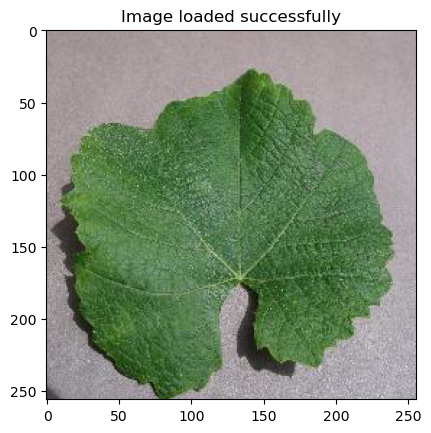

In [3]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image, device=torch.device("cpu")):
    #normalize = transforms.Normalize(
    #mean=[0.485, 0.456, 0.406],
    #std=[0.229, 0.224, 0.225]
    #)
    preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(), ])
    #normalize])

    if isinstance(image, torch.Tensor):
        # Convert the tensor to PIL Image
        image = transforms.ToPILImage()(image)
    image = preprocess(image).unsqueeze(0).to(device)
    return image

def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item())

def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

dir_label = 'Grape___healthy'
local_root_dir = r'/Users/noambuzaglo/Desktop/lilush/PlantVillage'

sample_image = load_image((local_root_dir + '/test/' + dir_label + '/0ce12a10-c6ff-494e-a927-5ddc809c707a___Mt.N.V_HL 8945.JPG'))

### <img src="icons/resized/helper_functions.png" style="height:50px;display:inline"> Useful Functions


LowRankLayer: Custom PyTorch module for a low-rank layer. It adapts a linear layer and includes parameters for rank control, scaling, and an option for Dimensionality Reduction Analysis (DoRA).

initialization_model: Initializes the specified model for transfer learning with Low-Rank Adaptation (LoRA) or Dimensionality Reduction Analysis (DoRA). It accepts arguments such as model architecture, number of output classes, rank, scaling parameter, and options for using DoRA and pretrained weights.

train_model: Trains the given model using the provided data loaders, loss function, and optimizer. It supports training for a specified number of epochs and returns the trained model along with a DataFrame containing training and validation results.

calculate_accuracy: Calculates the accuracy of the trained model on a given test dataset. It returns the model accuracy as a percentage and a confusion matrix for evaluating the model's performance across different classes


In [ ]:
# Define a custom PyTorch module for a low-rank layer
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        """
        Custom PyTorch module for a low-rank layer.

        Args:
            linear (nn.Linear): Linear layer to be adapted.
            rank (int): Controls the inner dimension of the matrices A and B.
            alpha (float): Scaling hyper-parameter applied to the output of the low-rank adaptation.
            use_dora (bool): Flag to indicate whether to use DoRA (Dimensionality Reduction Analysis).
        """
        self.use_dora = use_dora
        self.rank = rank
        self.alpha = alpha
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)

In [ ]:
def initialization_model(model_name, num_classes, rank, alpha, use_dora = True, use_pretrained=True):
   """
    Initializes the specified model for transfer learning with Low-Rank Adaptation (LoRA) or Dimensionality Reduction Analysis (DoRA).

    Args:
        model_name (str): Name of the model architecture.
        num_classes (int): Number of output classes.
        rank (int): Controls the inner dimension of the matrices A and B for LoRA.
        alpha (float): Scaling hyper-parameter applied to the output of the low-rank adaptation.
        use_dora (bool): Flag to indicate whether to use DoRA (Dimensionality Reduction Analysis).
        use_pretrained (bool): Flag to use pre-trained weights.

    Returns:
        model_ft (nn.Module): Initialized model.
        input_size (int): Input size expected by the model.
    """
    model_ft = None
    input_size = 0
    feature_extract = False

    # Define weights setting based on whether pretrained weights are desired.
    weights = 'DEFAULT' if use_pretrained else None

    if model_name == "resnet":
        # Initialize ResNet
        model_ft = models.resnet18(weights=weights)
        model_ft.requires_grad_(False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc =  LowRankLayer(model_ft.fc, rank, alpha, use_dora=use_dora)
        input_size = 224

    elif model_name == "alexnet":
        # Initialize AlexNet
        model_ft = models.alexnet(weights=weights)
        model_ft.requires_grad_(False)
        model_ft.classifier[4] =  LowRankLayer(model_ft.classifier[4], rank, alpha, use_dora=use_dora)
        # change the last linear layer to the correct number of classes
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

        input_size = 224

    elif model_name == "vgg":
        # Initialize VGG
        model_ft = models.vgg16(weights=weights)
        model_ft.requires_grad_(False)
        model_ft.classifier[3] =  LowRankLayer(model_ft.classifier[3], rank, alpha, use_dora=use_dora)
        # change the last linear layer to the correct number of classes
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet":
        # Initialize DenseNet
        model_ft = models.densenet121(weights=weights)
        model_ft.requires_grad_(False)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        model_ft.classifier =  LowRankLayer(model_ft.classifier, rank, alpha, use_dora=use_dora)
        # Note: DenseNet's input size is often larger in practice, but 224 works for compatibility.
        input_size = 224

    else:
        raise NotImplementedError("The specified model name is not supported.")

    return model_ft, input_size

In [ ]:
"""
Training function
"""
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=25):
    """
    Train the given model.

    Args:
        model (nn.Module): The model to be trained.
        model_name (str): Name of the model.
        dataloaders (dict): Dictionary containing data loaders for training and validation sets.
        criterion: The loss function.
        optimizer: The optimization algorithm.
        num_epochs (int): Number of epochs to train the model.

    Returns:
        model (nn.Module): The trained model.
        results (DataFrame): DataFrame containing training and validation results.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    results_list = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            epoch_acc = epoch_acc.cpu().numpy()  # Convert tensor to CPU
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            results_list.append(pd.DataFrame({'phase': [phase], 'epoch': [epoch], 'loss': [epoch_loss], 'accuracy': [epoch_acc.item()]}))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    results = pd.concat(results_list, ignore_index=True)

    # save model
    state = {
            'net': model.state_dict(),
            }
    if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
    torch.save(state, f'./checkpoints/{model_name}.pth')
    return model, results

In [ ]:
#  function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    """
    Calculate the accuracy of the model.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader containing the dataset.
        device (str): Device to perform computation ('cpu' or 'cuda').

    Returns:
        model_accuracy (float): The accuracy of the model.
        confusion_matrix (ndarray): Confusion matrix.
    """
    model.eval()
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([38, 38], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

### <img src="icons/resized/device.png" style="height:50px;display:inline"> Device
Define the device:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_built():
    print("using MPS")
    device = torch.device("mps")

### <img src="icons/resized/training.png" style="height:50px;display:inline">  Train

Create a function that initializes models based on the chosen parameters, allowing the selection of either dora  or lora. This function should also train the models and print the results on each epoch.

In [ ]:
def set_and_run_model(root_dir, model_name, file_name, use_dora=True):
    """
    Set up and run the model with the specified configurations.

    Args:
        root_dir (str): The root directory of the dataset.
        model_name (str): Name of the model to be used (e.g., 'resnet', 'alexnet', 'vgg', 'densenet').
        file_name (str): Name of the file to save the results.
        use_dora (bool): Flag for dora or lora.
                                When False, using lora.
                                When True, using dora.

    Returns:
        model_ft: The trained model.
    """
    root_dir = root_dir
    batch_size = 128
    dataloaders = create_dataloader(root_dir, batch_size)
    # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
    model_name = model_name
    # Number of classes in the dataset
    num_classes = 38
    # Batch size for training (change depending on how much memory you have)
    batch_size = 32
    # Number of epochs to train for
    num_epochs = 15
    # Flag for feature extracting. When False, we fine-tune the whole model,
    rank = 4
    alpha = 8
    model_ft, input_size = initialization_model(model_name, num_classes, rank, alpha, use_dora=use_dora, use_pretrained=True)
    # Print the model we just instantiated
    print(model_ft)

    # print and collect learnable paramters
    print("Params to learn:")
    params_to_update = []  # override the initial list definition above
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
    model_ft = model_ft.to(device)

    optimizer_ft = torch.optim.Adam(params_to_update, lr=0.0002)

    # Setup the loss fn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft, results = train_model(model_ft, file_name, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)
    results.to_csv(f"results_{file_name}.csv", index=False)
    return model_ft

using MPS


### <img src="icons/resized/test.png" style="height:50px;display:inline">  Test
Verify the accuracy of the model using the test dataset.

In [ ]:
def run_test_data(root_dir, model):
    """
    Run the test data on the trained model and calculate the test accuracy.

    Args:
        root_dir (str): The root directory of the dataset.
        model: The trained model.
        batch_size (int): Batch size for loading the test data.

    Returns:
        float: Test accuracy.
    """
    test_transform = transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
    batch_size = 128
    test_dataset = ImageFolder(root=root_dir + '/test', transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

    test_accuracy, _ = calculate_accuracy(model, test_loader, device)
    print(f"test accuracy:{test_accuracy}")

In [ ]:
root_dir = r'/Users/noambuzaglo/Desktop/lilush/PlantVillage'

### <img src="icons/resized/dora.png" style="height:50px;display:inline">DoRA
Train and evaluate all selected pre-trained models using DoRA: AlexNet, VGG, ResNet, DenseNet

In [ ]:
# run alexnet with dora:
alexnet_dora = set_and_run_model(root_dir, 'alexnet', 'alexnet_dora', use_dora=True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
run_test_data(root_dir, alexnet_dora)

test accuracy:87.52310536044362


In [ ]:
# run vgg with dora:
vgg_dora = set_and_run_model(root_dir, 'vgg', 'vgg_dora', use_dora=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
run_test_data(root_dir, vgg_dora)

test accuracy:84.58872458410352


In [ ]:
# run densenet with dora:
densent_dora = set_and_run_model(root_dir, 'densenet', 'densenet_dora', use_dora=True)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
run_test_data(root_dir, densent_dora)

test accuracy:92.5369685767098


In [ ]:
# run resnet with dora:
resnet_dora = set_and_run_model(root_dir, 'resnet', 'resnet_dora', use_dora=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
run_test_data(root_dir, resnet_dora)

test accuracy:89.78743068391867


### <img src="icons/resized/matrix.png" style="height:50px;display:inline">  Lora
Train and evaluate all selected pre-trained models using LoRA: AlexNet, VGG, ResNet, DenseNet

In [ ]:
# run alexnet with lora:
alexnet_lora = set_and_run_model(root_dir, 'alexnet', 'alexnet_lora', use_dora=False)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
run_test_data(root_dir, alexnet_lora)

test accuracy:87.86968576709798


In [ ]:
# run vgg with lora:
vgg_lora = set_and_run_model(root_dir, 'vgg', 'vgg_lora', use_dora=False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
run_test_data(root_dir, vgg_lora)

test accuracy:83.27171903881701


In [ ]:
# run densenet with lora:
densenet_lora = set_and_run_model(root_dir, 'densenet', 'densenet_lora', use_dora=False)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
run_test_data(root_dir, densenet_lora)

test accuracy:91.38170055452865


In [ ]:
# run resnet with lora:
resnet_lora = set_and_run_model(root_dir, 'resnet', 'resnet_lora', use_dora=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
run_test_data(root_dir, resnet_lora)

test accuracy:89.44085027726433
